
## Cork Institute of Technology

### MSc in Data Science and Analytics

## Applied Machine Learning 
## Project 3 Assignment

#### Givaldo Francisco S Jr

R00182595


I was trying to activete my GPU

In [1]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0', '/device:XLA_CPU:0', '/device:XLA_GPU:0']


In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### Import libraries

In [3]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os



### Define image properties

In [4]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

# load images from train folder

### Prepare dataset for training model

In [5]:
filenames = os.listdir("train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [6]:
df.head()

filename  category
0    cat.0.jpg         0
1    cat.1.jpg         0
2   cat.10.jpg         0
3  cat.100.jpg         0
4  cat.101.jpg         0

In [7]:
df.tail()

filename  category
997   dog.95.jpg         1
998   dog.96.jpg         1
999   dog.97.jpg         1
1000  dog.98.jpg         1
1001  dog.99.jpg         1

### total image of cat and dog

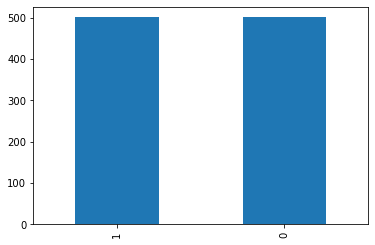

In [8]:
df['category'].value_counts().plot.bar()

### Selecting one sample image

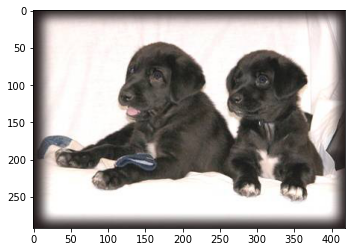

In [9]:
sample = random.choice(filenames)
image = load_img("train/"+sample)
plt.imshow(image)

## Creating the neural net model

the image needs to be converted into a vector of numbers

Instead of feeding the entire image as an array of numbers, the image is broken up into a number of tiles, the machine then tries to predict what each tile is. Finally, the computer tries to predict what’s in the picture based on the prediction of all the tiles. This allows the computer to parallelize the operations and detect the object regardless of where it is located in the image.

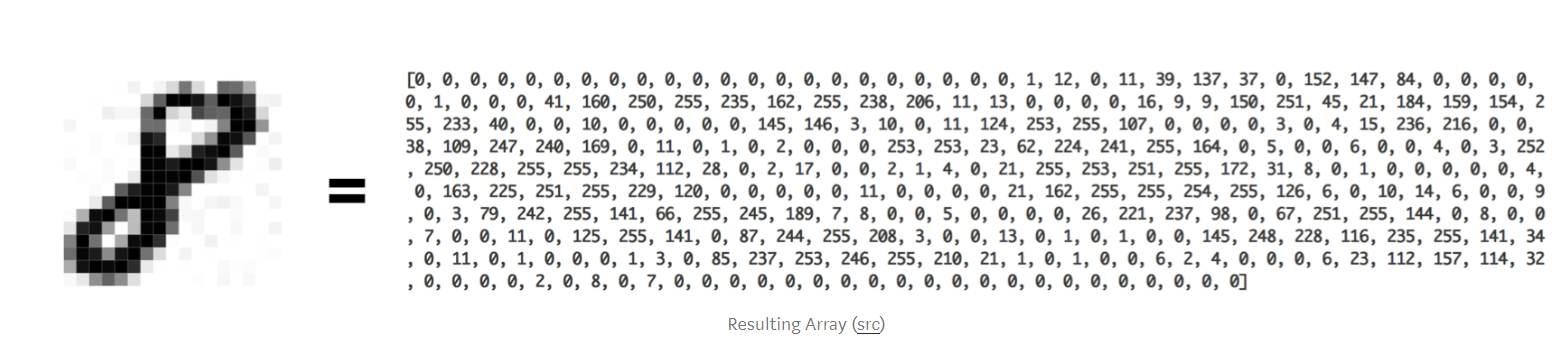

### BatchNormalization

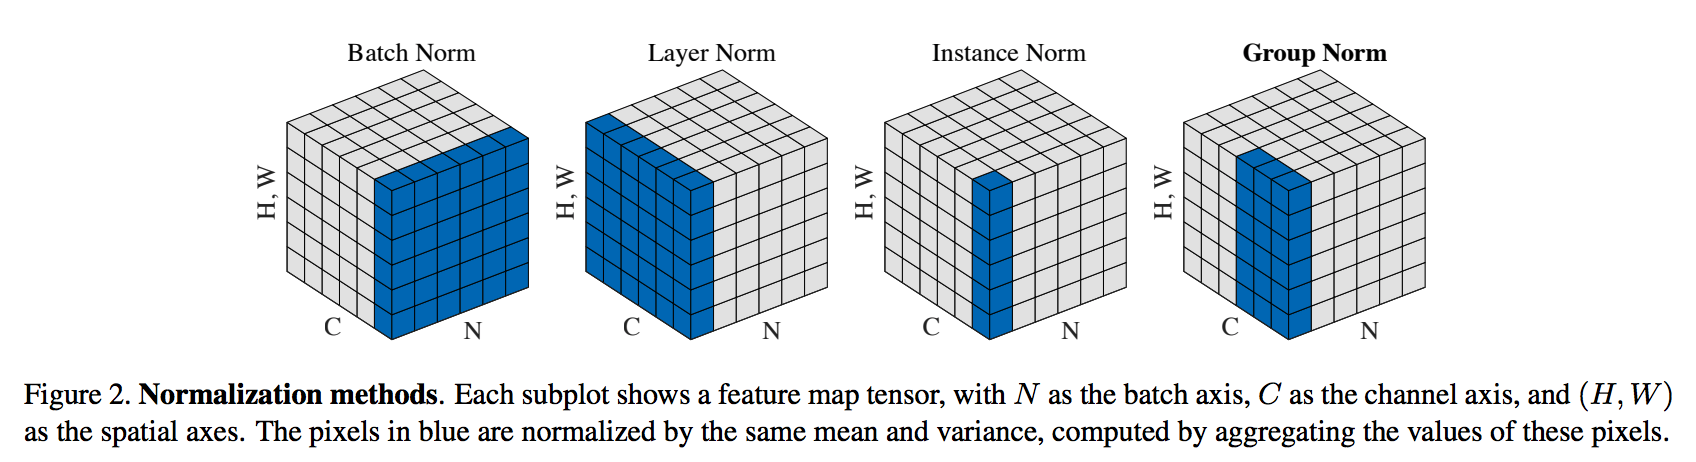

It is a technique designed to automatically standardize the inputs to a layer in a deep learning neural network.

### Maxpooling

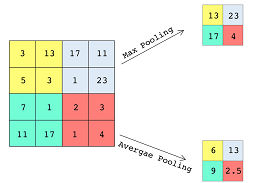

### dropout

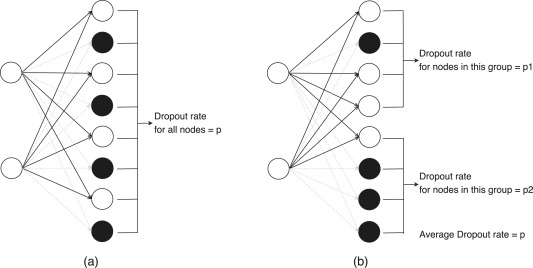

### ReLU

Some neurons stuck in the negative side and always get outputs 0, ReLU remove these neurons that are essentially useless.

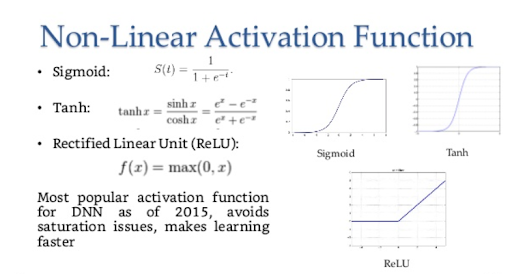

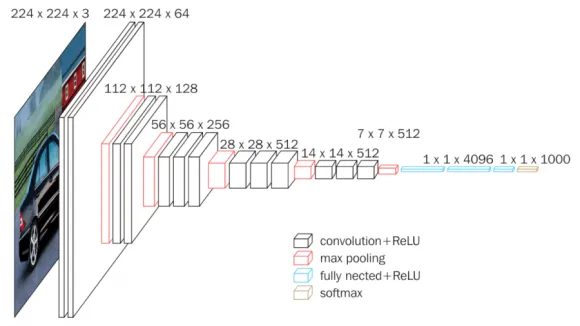

In [10]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

## Define callbacks and learning rate

A custom callback is a powerful tool to customize the behavior of a Keras model during training, evaluation, or inference, including reading/changing the Keras model. Examples include tf.keras.callbacks.TensorBoard where the training progress and results can be exported and visualized with TensorBoard, or tf.keras.callbacks.ModelCheckpoint where the model is automatically saved during training, and more.

In [11]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [12]:
earlystop = EarlyStopping(patience=10)

In machine learning, early stop is a form of regularization used to avoid excessive adjustments when training a student with an iterative method, such as gradient descent. These methods update the student to better match the training data with each iteration.

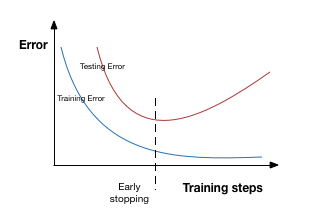

In [13]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.

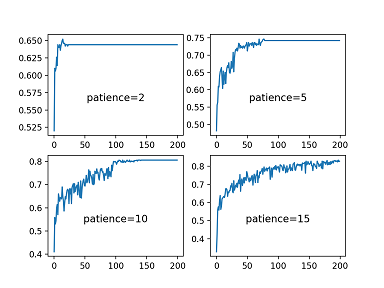

In [14]:
callbacks = [earlystop, learning_rate_reduction]

In [15]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

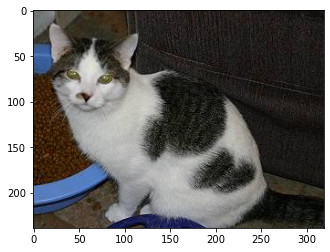

In [16]:
sample = random.choice(df['filename'])
image = load_img("train/"+sample)
plt.imshow(image)

In [17]:
train_df, validate_df = train_test_split(df, test_size=0.30, random_state=25)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [18]:
validate_df

filename category
0    dog.192.jpg      dog
1    cat.142.jpg      cat
2    cat.358.jpg      cat
3    cat.491.jpg      cat
4    dog.319.jpg      dog
..           ...      ...
296  cat.287.jpg      cat
297  cat.365.jpg      cat
298  dog.408.jpg      dog
299  cat.155.jpg      cat
300   cat.42.jpg      cat

[301 rows x 2 columns]

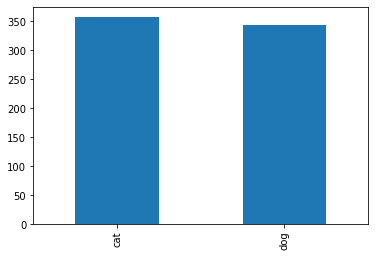

In [19]:
train_df['category'].value_counts().plot.bar()

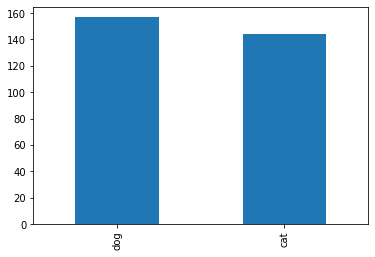

In [20]:
validate_df['category'].value_counts().plot.bar()

# training

In [21]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=10

In [22]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 701 validated image filenames belonging to 2 classes.


### ImageDataGenerator

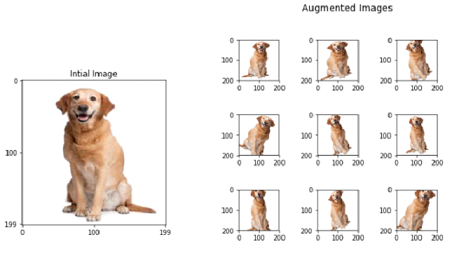

Image data augmentation is a technique that can be used to artificially expand the size of a training dataset by creating modified versions of images in the dataset. 

In [23]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 301 validated image filenames belonging to 2 classes.


In [24]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


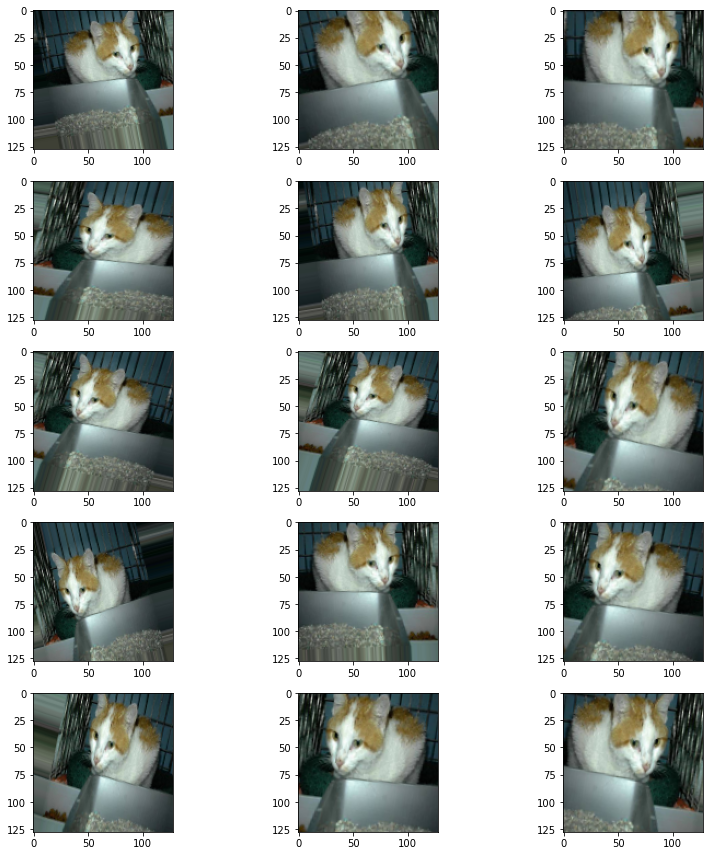

In [25]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

### fit_generator() function

fit_generator() function. our . fit_generator() function first accepts a batch of the dataset, then performs backpropagation on it, and then updates the weights in our model. For the number of epochs specified(10 in our case) the process is repeated

When we call the .fit_generator() function it makes assumptions:

Keras is first calling the generator function(dataAugmentaion)
Generator function(dataAugmentaion) provides a batch_size of 32 to our .fit_generator() function.
our .fit_generator() function first accepts a batch of the dataset, then performs backpropagation on it, and then updates the weights in our model.
For the number of epochs specified(10 in our case) the process is repeated.

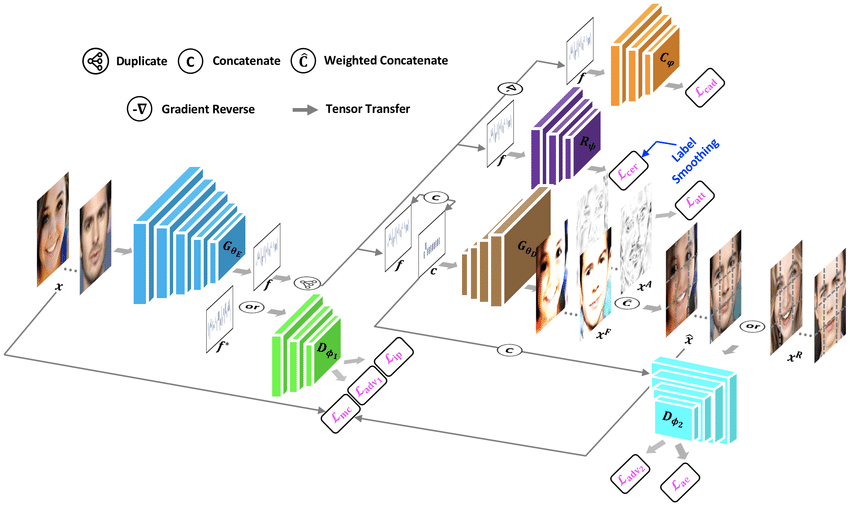

In [26]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
70/70 [==============================] - 44s 630ms/step - loss: 1.3065 - accuracy: 0.5847 - val_loss: 7.2188 - val_accuracy: 0.4800
Epoch 2/50
70/70 [==============================] - 40s 571ms/step - loss: 1.1658 - accuracy: 0.5557 - val_loss: 5.7205 - val_accuracy: 0.4767
Epoch 3/50
70/70 [==============================] - 43s 616ms/step - loss: 0.9874 - accuracy: 0.5702 - val_loss: 3.3360 - val_accuracy: 0.4767
Epoch 4/50
70/70 [==============================] - 44s 624ms/step - loss: 0.9386 - accuracy: 0.5847 - val_loss: 1.1346 - val_accuracy: 0.5167
Epoch 5/50
70/70 [==============================] - 40s 569ms/step - loss: 0.7984 - accuracy: 0.6266 - val_loss: 2.0274 - val_accuracy: 0.4800
Epoch 6/50
70/70 [==============================] - 44s 626ms/step - loss: 0.7148 - accuracy: 0.6512 - val_loss: 0.8969 - val_accuracy: 0.5200
Epoch 7/50
70/70 [==============================] - 37s 528ms/step

Epoch 22/50
70/70 [==============================] - 40s 576ms/step - loss: 0.5139 - accuracy: 0.7482 - val_loss: 0.7751 - val_accuracy: 0.6367
Epoch 23/50
70/70 [==============================] - 41s 586ms/step - loss: 0.5203 - accuracy: 0.7554 - val_loss: 0.6509 - val_accuracy: 0.6633
Epoch 24/50
70/70 [==============================] - 39s 560ms/step - loss: 0.5368 - accuracy: 0.7395 - val_loss: 0.6316 - val_accuracy: 0.7167
Epoch 25/50
70/70 [==============================] - 40s 565ms/step - loss: 0.5472 - accuracy: 0.7308 - val_loss: 0.7778 - val_accuracy: 0.6033
Epoch 26/50
70/70 [==============================] - 39s 562ms/step - loss: 0.5116 - accuracy: 0.7482 - val_loss: 0.7653 - val_accuracy: 0.6633


In [27]:
history.epoch

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25]

In [28]:
model.save_weights("model.h5")

### Ploting Training loss, Validation loss, Training accuracy and Validation accuracy

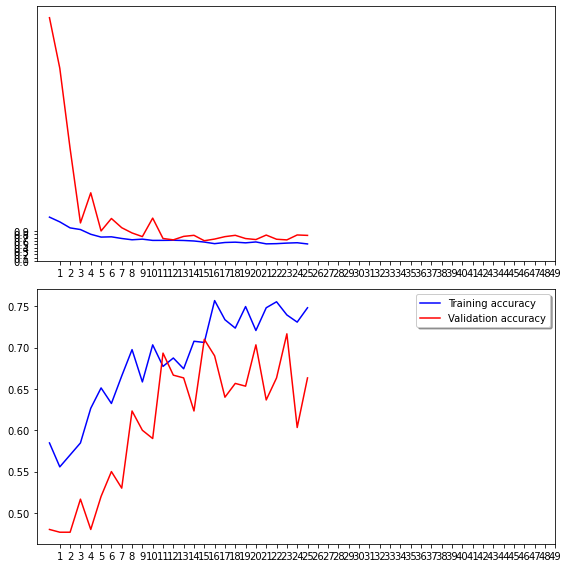

In [29]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))


ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

### load files from test1 folder

In [30]:
test_filenames = os.listdir("test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [31]:
### using flow_from_dataframe function 

In [32]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 100 validated image filenames.


### predict_generator

In [33]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

Instructions for updating:
Please use Model.predict, which supports generators.


For categoral classication the prediction will come with probability of each category. So we will pick the category that have the highest probability with numpy average max

In [34]:
test_df['category'] = np.argmax(predict, axis=-1)

We will convert the predict category back into our generator classes by using `train_generator.class_indices`. It is the classes that image generator map while converting data into computer vision

In [35]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

From our prepare data part. We map data with `{1: 'dog', 0: 'cat'}`. Now we will map the result back to dog is 1 and cat is 0

In [36]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

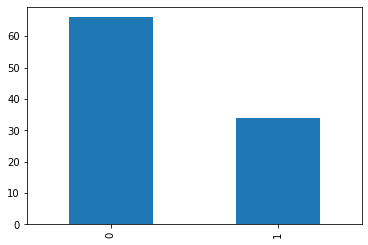

In [37]:
test_df['category'].value_counts().plot.bar()

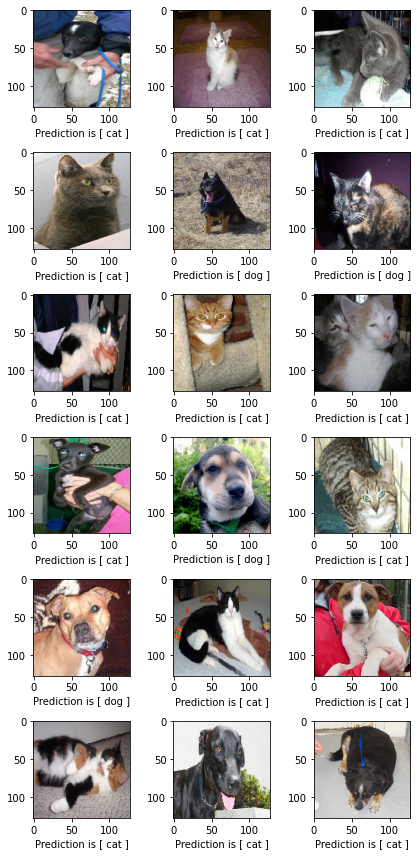

In [38]:

sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(6, 12))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    if(category==0):
        out='cat'
    else:
        out='dog'
    #plt.xlabel(filename + '(' + "{}".format(category) + ')' )
    plt.xlabel("Prediction is [ "+out+" ]")
plt.tight_layout()
plt.show()

# Submission

In [39]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)

# -------------------------------------------------------------------------------------------------------------

# Changing the hyperparameters

# Using 25000 train images

In [40]:
filenames = os.listdir("train2")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

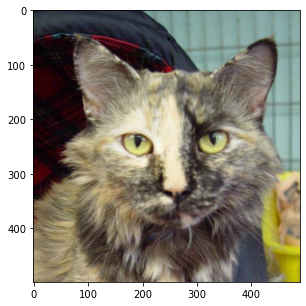

In [41]:
plt.figure(figsize=(5, 5))
image = load_img("train2/"+df['filename'][2])
plt.imshow(image)

In [42]:
df.shape

(25001, 2)

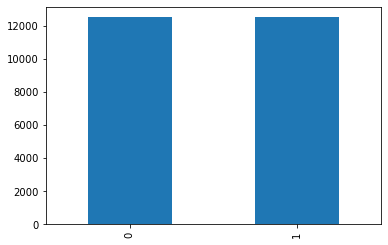

In [43]:
df['category'].value_counts().plot.bar()

In [44]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [45]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

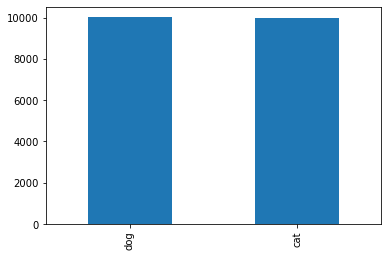

In [46]:
train_df['category'].value_counts().plot.bar()

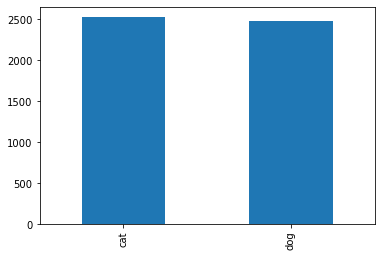

In [47]:
validate_df['category'].value_counts().plot.bar()

In [48]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [49]:
train_datagen = ImageDataGenerator(
    rotation_range=10, 
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "train2/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 19999 validated image filenames belonging to 2 classes.


c:\Users\gival\anaconda3\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [50]:
train_generator.color_mode

'rgb'

In [51]:
train_generator.batch_size

15

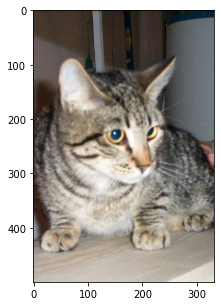

In [53]:
plt.figure(figsize=(5, 5))
image = load_img("train2/"+train_generator.filenames[5])
plt.imshow(image)

### Bellow we can see the image in real size

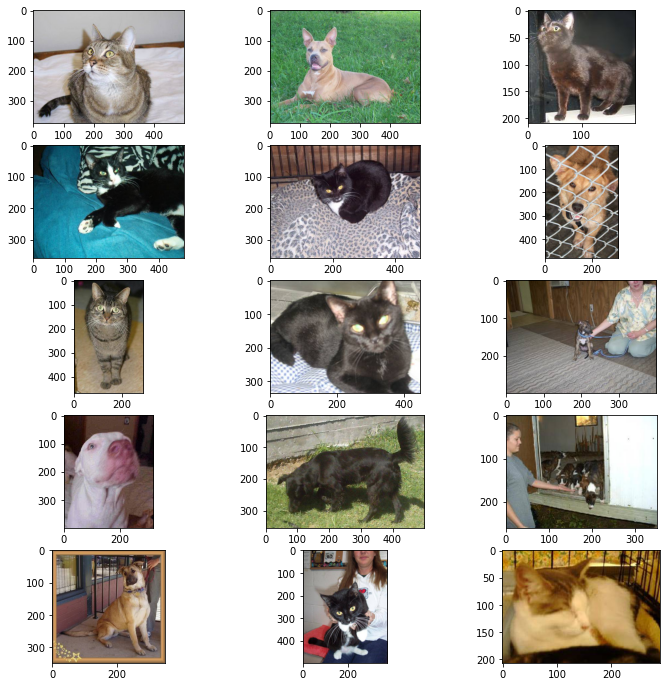

In [54]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)   
    sample = random.choice(train_generator.filenames)
    image = load_img("train2/"+sample)
    plt.imshow(image)

In [55]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "train2/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5001 validated image filenames belonging to 2 classes.


In [56]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "train2/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


### Bellow we can see all images with the same size and rotated

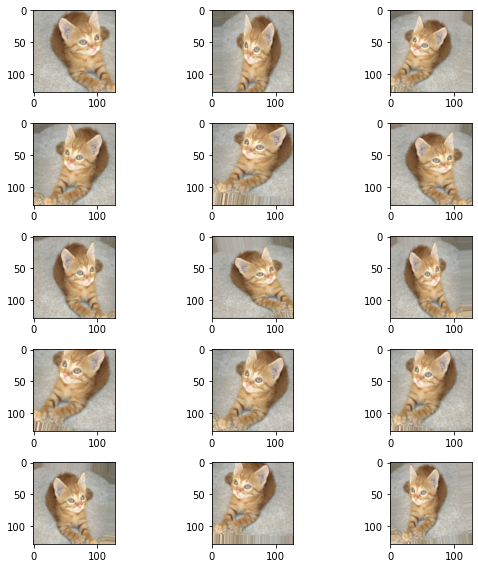

In [57]:
plt.figure(figsize=(8, 8))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [58]:
epochs=3 if FAST_RUN else 5
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/5
1333/1333 [==============================] - 1008s 756ms/step - loss: 0.5786 - accuracy: 0.7052 - val_loss: 0.6543 - val_accuracy: 0.6865
Epoch 2/5
1333/1333 [==============================] - 1201s 901ms/step - loss: 0.5108 - accuracy: 0.7544 - val_loss: 0.5894 - val_accuracy: 0.7654
Epoch 3/5
1333/1333 [==============================] - 982s 737ms/step - loss: 0.4644 - accuracy: 0.7857 - val_loss: 0.4906 - val_accuracy: 0.7772
Epoch 4/5
1333/1333 [==============================] - 1015s 762ms/step - loss: 0.4402 - accuracy: 0.7970 - val_loss: 1.0984 - val_accuracy: 0.5922
Epoch 5/5
1333/1333 [==============================] - 1010s 758ms/step - loss: 0.4206 - accuracy: 0.8112 - val_loss: 0.3892 - val_accuracy: 0.8290


In [59]:
model.save_weights("model.h5")

In [60]:
history.history

{'loss': [0.5785732865333557,
  0.5108222961425781,
  0.4643590748310089,
  0.440235435962677,
  0.42056477069854736],
 'accuracy': [0.7052141427993774,
  0.7544035315513611,
  0.7857285737991333,
  0.7969875931739807,
  0.8111989498138428],
 'val_loss': [0.6542791128158569,
  0.5893730521202087,
  0.49055764079093933,
  1.098372459411621,
  0.3892408013343811],
 'val_accuracy': [0.6864864826202393,
  0.7653653621673584,
  0.7771771550178528,
  0.5921921730041504,
  0.8290290236473083],
 'lr': [0.001, 0.001, 0.001, 0.001, 0.001]}

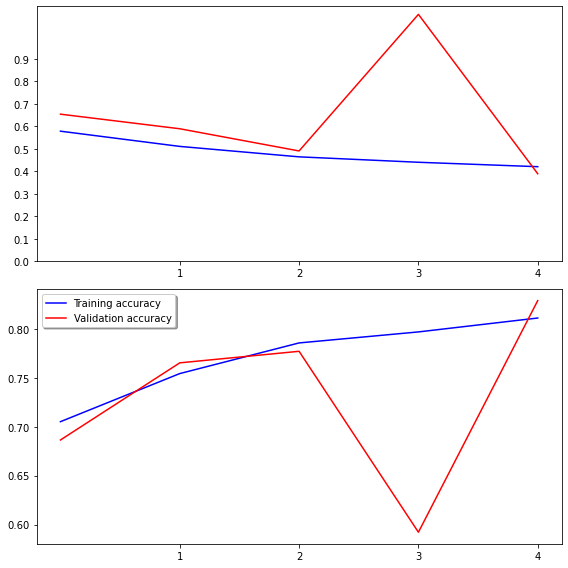

In [61]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))


ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [62]:
test_filenames = os.listdir("test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [63]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 100 validated image filenames.


In [64]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

For categoral classication the prediction will come with probability of each category. So we will pick the category that have the highest probability with numpy average max

In [65]:
test_df['category'] = np.argmax(predict, axis=-1)

We will convert the predict category back into our generator classes by using `train_generator.class_indices`. It is the classes that image generator map while converting data into computer vision

In [66]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

From our prepare data part. We map data with `{1: 'dog', 0: 'cat'}`. Now we will map the result back to dog is 1 and cat is 0

In [67]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

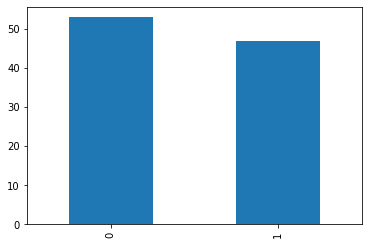

In [68]:
test_df['category'].value_counts().plot.bar()

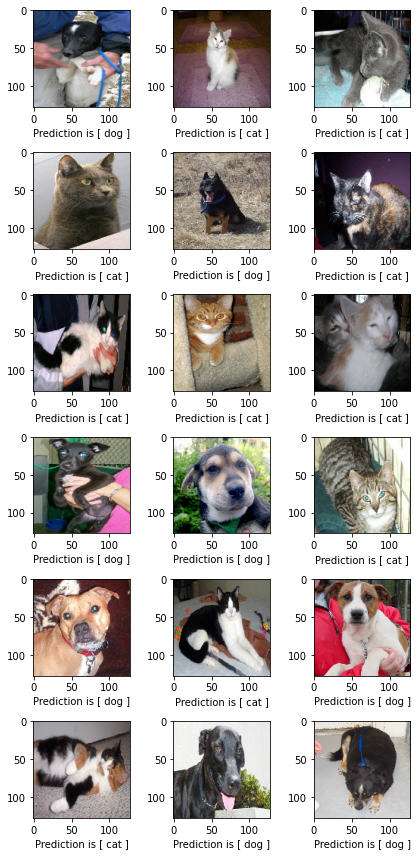

In [69]:

sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(6, 12))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    if(category==0):
        out='cat'
    else:
        out='dog'
    #plt.xlabel(filename + '(' + "{}".format(category) + ')' )
    plt.xlabel("Prediction is [ "+out+" ]")
plt.tight_layout()
plt.show()

In [70]:

from os import listdir
from os.path import join, basename
from PIL import Image

print(listdir("."))
IMG_HEIGHT = 50
IMG_WIDTH = 50
NUM_CHANNELS = 3

from threading import current_thread, Thread, Lock
from multiprocessing import Queue
# Any results you write to the current directory are saved as output.

['.ipynb_checkpoints', 'cats vs dogs classification with CNN keras.ipynb', 'CatsvsDogs.ipynb', 'classification cat and dogs.ipynb', 'Dogs vs. Cats Classification (VGG16 Fine Tuning).ipynb', 'Full Classification Example with ConvNet.ipynb', 'Givaldo-v2.ipynb', 'Givaldo_R00182595.ipynb', 'Keras CNN Dog or Cat Classification.ipynb', 'model.h5', 'sampleSubmission.csv', 'submission.csv', 'Test Time Augmentation (TTA) ... worth it_.ipynb', 'test1', 'test1.zip', 'test_arr.pickle', 'train', 'train2', 'train2.zip', 'train_arr.pickle', 'train_data.npy', 'train_labels.pickle']


In [71]:
# use of queue for collecting results from threads
def initialize_queue():
    queue = Queue()
    return queue

In [72]:
train_dir_path = "train"
test_dir_path = "test1"

train_imgs = [join(train_dir_path,f) for f in listdir(train_dir_path)]
test_imgs = [join(test_dir_path,f) for f in listdir(test_dir_path)]
print(len(train_imgs))
print(len(test_imgs))

1002
100


In [73]:
# initializations related to threading stuff
batch_size = 4
num_train_images = len(train_imgs)
num_test_images = len(test_imgs)
num_train_threads = int(num_train_images/4)  # 50
num_test_threads = int(num_test_images/4)    # 25
lock = Lock()

In [74]:
# one hot encode labels based on name of image file
def get_img_label(fpath):
    category = fpath.split(".")[-3]
    if category == "dog":
        return [1,0]
    elif category == "cat":
        return [0,1]

In [75]:
def get_img_array_labels(fpaths, queue):
    img_array = None
    labels = []
    for f in fpaths:
        arr = Image.open(f)
        arr = arr.resize((IMG_HEIGHT,IMG_WIDTH), Image.ANTIALIAS)
        arr = np.reshape(arr, (-1, IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS))
        if img_array is None:
            img_array = arr
        else:
            img_array = np.vstack((img_array, arr))
        labels.append(get_img_label(basename(f)))
    labels = np.array(labels)
    queue.put((img_array, labels))

In [76]:
# convert testing images to numpy array
def get_img_array(fpaths, queue):
    img_array = None
    for f in fpaths:
        arr = Image.open(f)
        arr = arr.resize((IMG_HEIGHT,IMG_WIDTH), Image.ANTIALIAS)
        arr = np.reshape(arr, (-1, IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS))
        if img_array is None:
            img_array = arr
        else:
            img_array = np.vstack((img_array, arr))        
    queue.put(img_array)

In [77]:
def dump_array(fname,arr):
    with open(fname,'wb') as f:
        pickle.dump(arr,f)

In [78]:
def load_pickled_array(fname,arr):
    with open(fname, 'rb') as f:
        return pickle.load(f)

In [79]:
# using threading combine training array and labels for training data
def get_training_data():
    threads_list = list()
    train_x = None
    train_y = []
    queue = initialize_queue()
    # iterate over num of threads to create
    for thread_index in range(num_train_threads):
        start_index = thread_index * batch_size
        end_index = (thread_index + 1) * batch_size
        file_batch = train_imgs[start_index:end_index]
        thread = Thread(target =get_img_array_labels, args=(file_batch, queue))
        thread.start()
        #print("Thread: {}, start index: {}, end index: {}".format(thread.name, start_index, end_index))
        threads_list.append(thread)
    
    # join threads
    for t in threads_list:
        t.join()
    while not queue.empty():
        arr, labels = queue.get()
        train_y.extend(labels)
        if train_x is None:
            train_x = arr
        else:
            train_x = np.vstack((train_x, arr))
    return train_x, train_y

In [80]:
# using multithreading combine testing array for testing data
def get_testing_data():
    threads_list = list()
    test_x = None
    queue = initialize_queue()
    # iterate over num of threads to create
    for thread_index in range(num_test_threads):
        start_index = thread_index * batch_size
        end_index = (thread_index + 1) * batch_size
        file_batch = train_imgs[start_index:end_index]
        thread = Thread(target =get_img_array, args=(file_batch, queue))
        thread.start()
        #print("Thread: {}, start index: {}, end index: {}".format(thread.name, start_index, end_index))
        threads_list.append(thread)
    
    # join threads
    for t in threads_list:
        t.join()
        print( t.name)
        
    while not queue.empty():
        arr= queue.get()
        if test_x is None:
            test_x = arr
        else:
            test_x = np.vstack((test_x, arr))
            
    return test_x

In [81]:
# convert training images to train_x and train_y
train_x, train_y = get_training_data()

In [82]:
print(train_x.shape)
print(len(train_y))
test_x = get_testing_data()


(1000, 50, 50, 3)
1000
Thread-257
Thread-258
Thread-259
Thread-260
Thread-261
Thread-262
Thread-263
Thread-264
Thread-265
Thread-266
Thread-267
Thread-268
Thread-269
Thread-270
Thread-271
Thread-272
Thread-273
Thread-274
Thread-275
Thread-276
Thread-277
Thread-278
Thread-279
Thread-280
Thread-281


In [83]:
test_x.shape

(100, 50, 50, 3)

In [85]:
# dump training data
import pickle
dump_array('train_arr.pickle',train_x)
dump_array('train_labels.pickle',train_y)

In [86]:
# dump testing data
dump_array('test_arr.pickle',test_x)

In [87]:

# convert train_y to np. array
train_y = np.array(train_y)
print("train_y.shape", train_y.shape)

train_y.shape (1000, 2)


In [88]:
# mean normalize train and test images
train_x = train_x/255
test_x = test_x/255

In [90]:
# CNN model
# CNN model
model = Sequential()

# -----------------------------------------------------------------------------------
# conv 1
model.add(Conv2D(16, (3,3), input_shape=(50,50,3))) # 148,148,32
model.add(BatchNormalization(axis=3))
model.add(Activation('relu'))
#model.add(Dropout(0.5))

# max pool 1
model.add(MaxPooling2D(pool_size=(2,2),strides=2))          # 72,72,32

# -----------------------------------------------------------------------------------
# conv 2
model.add(Conv2D(16, (3,3)))                      # 68,68,32
model.add(BatchNormalization(axis=3))
model.add(Activation('relu'))
#model.add(Dropout(0.5))

# max pool 2
model.add(MaxPooling2D(pool_size=(2,2),strides=2))          # 34,34,32
# -----------------------------------------------------------------------------------

# conv 3
model.add(Conv2D(32, (3,3)))                      # 32,32,32
model.add(BatchNormalization(axis=3))
model.add(Activation('relu'))
#model.add(Dropout(0.7))

# max pool 3
model.add(MaxPooling2D(pool_size=(2,2),strides=2))          # 17,17,32
# -----------------------------------------------------------------------------------

# conv 4
model.add(Conv2D(32, (3,3)))                      # 15,15,32
model.add(BatchNormalization(axis=3))
model.add(Activation('relu'))
#model.add(Dropout(0.7))
# max pool 4
model.add(MaxPooling2D(pool_size=(2,2),strides=2))  # 7,7,32

# flatten
model.add(Flatten())


# fc layer 1
model.add(Dense(512, activation='relu'))

#model.add(Dropout(0.7))

#model.add(Dense(256, activation='relu'))

#model.add(Dropout(0.5))

# fc layer 2
model.add(Dense(2, activation='softmax'))


In [91]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [92]:
#model.(valdn_x, valdn_y, batch_size=32, verbose=1)
predictions = model.predict(test_x, batch_size=32, verbose=3)

In [93]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 48, 48, 16)        448       
_________________________________________________________________
batch_normalization_4 (Batch (None, 48, 48, 16)        64        
_________________________________________________________________
activation (Activation)      (None, 48, 48, 16)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 22, 22, 16)        2320      
_________________________________________________________________
batch_normalization_5 (Batch (None, 22, 22, 16)        64        
_________________________________________________________________
activation_1 (Activation)    (None, 22, 22, 16)       

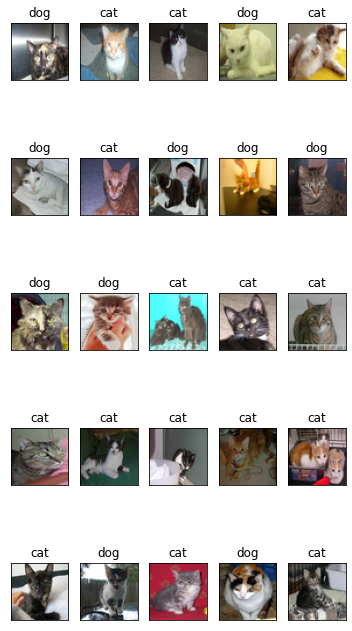

In [94]:
import matplotlib.pyplot as plt
%matplotlib inline
fig=plt.figure(figsize=(6, 12))


for index in range(25):
    # cat: [1,0]
    # dog: [0,1]
    y = fig.add_subplot(5,5,index+1)
    #model_out = model.predict([data])
    img = test_x[index]
    model_out = predictions[index]
    
    if np.argmax(model_out) == 0: str_label='dog'
    else: str_label='cat'
        
    y.imshow(img)
    plt.title(str_label)
  
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

In [95]:
with open('submission.csv','w') as f:
    f.write('id,label\n')
    for index in range(len(test_imgs)):
        img_id =basename(test_imgs[index]).split(".")[0]
        prob = (predictions[index,0])
        #print("index: {}, img_id: {}, prob:{}".format(index,img_id, prob))
        f.write("{},{}\n".format(img_id, prob))